# Kinases

This notebook will focus on curating a **kinase dataset**. In the Volkamer lab, we normally have kinases as our target.
In a nutshell, **kinases are a family of enzymes** that play a critical role in cellular signaling by **transferring phosphate groups from ATP to specific substrates**, typically proteins. This phosphorylation process regulates various biological activities, including cell growth, differentiation, and metabolism. Due to their involvement in many cellular processes, kinases are key targets in drug discovery, particularly for treating **cancers**, cardiovascular diseases and other diseases linked to abnormal kinase activity.

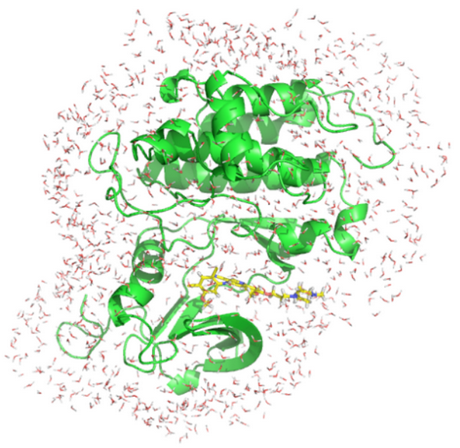

# ChEMBL
ChEMBL (https://www.ebi.ac.uk/chembl/) is a manually curated database of bioactive molecules with drug-like properties, bringing together chemical, bioactivity and genomic data.






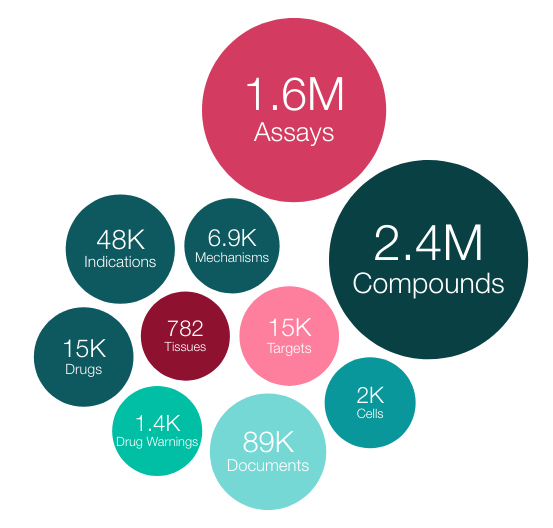

*Source: https://www.ebi.ac.uk/chembl/*

In our research group we use ChEMBL since it stores a good amount of bioactivities for **kinase-ligand complexes**.  In this notebook, we will do **data preprocessign** on ChEMBL kinase bioactivity data as well as some **preliminary data analysis** and **data splitting**.

In [ ]:
!pip install rdkit distinctipy

In [ ]:
import pandas as pd
import tqdm.notebook as tqdm
import numpy as np
import requests as req
import functools

# cheminformatics
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw

# machine learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
import distinctipy


Here we will provide you with a non-curated versioned csv file with all kinase-ligand complexes on ChEMBL.

In [ ]:
!wget -q https://github.com/openkinome/kinodata/releases/download/v0.5/activities-chembl33-not-curated_v0.5.zip

!unzip activities-chembl33-not-curated_v0.5.zip

Archive:  activities-chembl33-not-curated_v0.5.zip
replace activities-chembl33-not-curated_v0.5.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!file activities-chembl33-not-curated_v0.5.zip

In [ ]:
kinodata = pd.read_csv("activities-chembl33-not-curated_v0.5.csv", index_col=0).set_index(
    "activities.activity_id"
)
kinodata = kinodata[
    ~kinodata["compound_structures.canonical_smiles"].str.contains("\\.").astype(bool)
] #removing faulty SMILES

<ipython-input-119-4f30c413338c>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  kinodata = pd.read_csv("activities-chembl33-not-curated_v0.5.csv", index_col=0).set_index(


In [ ]:
kinodata

,assays.chembl_id,target_dictionary.chembl_id,molecule_dictionary.chembl_id,molecule_dictionary.max_phase,activities.standard_type,activities.standard_value,activities.standard_units,compound_structures.canonical_smiles,compound_structures.standard_inchi,component_sequences.sequence,assays.confidence_score,docs.chembl_id,docs.year,docs.authors,UniprotID
activities.activity_id,,,,,,,,,,,,,,,
32260,CHEMBL674637,CHEMBL203,CHEMBL68920,NaN,pIC50,7.387216,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,InChI=1S/C19H15ClFN5O/c1-9-5-10(2)24-15(9)7-12...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,CHEMBL1134862,2002.0,"Sun L, Cui J, Liang C, Zhou Y, Nematalla A, Wa...",P00533
32262,CHEMBL816964,CHEMBL279,CHEMBL68920,NaN,pIC50,4.782516,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,InChI=1S/C19H15ClFN5O/c1-9-5-10(2)24-15(9)7-12...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,8,CHEMBL1134862,2002.0,"Sun L, Cui J, Liang C, Zhou Y, Nematalla A, Wa...",P35968
32267,CHEMBL674637,CHEMBL203,CHEMBL69960,NaN,pIC50,6.769551,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,InChI=1S/C23H20ClFN6O3/c1-12-8-18(23(33)31-4-6...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,CHEMBL1134862,2002.0,"Sun L, Cui J, Liang C, Zhou Y, Nematalla A, Wa...",P00533
32330,CHEMBL842023,CHEMBL258,CHEMBL69638,NaN,pIC50,6.853872,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,InChI=1S/C23H22N4O/c24-22-21-20(14-27(17-8-4-5...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,9,CHEMBL1132739,2000.0,"Arnold LD, Calderwood DJ, Dixon RW, Johnston D...",P06239
32331,CHEMBL842019,CHEMBL258,CHEMBL69638,NaN,pIC50,5.928118,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,InChI=1S/C23H22N4O/c24-22-21-20(14-27(17-8-4-5...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,9,CHEMBL1132739,2000.0,"Arnold LD, Calderwood DJ, Dixon RW, Johnston D...",P06239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24964043,CHEMBL5216703,CHEMBL299,CHEMBL5219806,NaN,pKi,7.000000,nM,CC(C)[C@@]12C[C@@H](C[C@@H](CCCCc3ccccc3)O1)OC...,InChI=1S/C25H36O7/c1-18(2)25-16-21(30-24(28)15...,MADVFPGNDSTASQDVANRFARKGALRQKNVHEVKDHKFIARFFKQ...,9,CHEMBL5214934,2022.0,"Sekido T, Yamamoto K, Yanagita RC, Kawamani Y,...",P17252
24964044,CHEMBL5216703,CHEMBL299,CHEMBL5220744,NaN,pKi,7.055517,nM,CC1(C)CC[C@@H]2CC(=O)O[C@@H](CO)CC(=O)O[C@H](C...,InChI=1S/C27H40O6/c1-27(2)15-14-22-17-25(29)33...,MADVFPGNDSTASQDVANRFARKGALRQKNVHEVKDHKFIARFFKQ...,9,CHEMBL5214934,2022.0,"Sekido T, Yamamoto K, Yanagita RC, Kawamani Y,...",P17252
24964045,CHEMBL5216704,CHEMBL2996,CHEMBL1258117,NaN,pKi,8.008774,nM,CC1(C)CC[C@@H]2CC(=O)O[C@@H](CO)CC(=O)O[C@@H]3...,InChI=1S/C27H38O7/c1-26(2)13-12-21-15-24(29)32...,MAPFLRIAFNSYELGSLQAEDEANQPFCAVKMKEALSTERGKTLVQ...,9,CHEMBL5214934,2022.0,"Sekido T, Yamamoto K, Yanagita RC, Kawamani Y,...",Q05655


## Find the quiz link!

In this session we will have an interactive quiz, so please join from your laptop or phone

Link: https://freeonlinesurveys.com/s/su4xnwGB


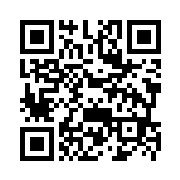

# 1. DATA CURATION
The following list is compiled from lessons learned in Kramer's *J. Med. Chem. 2012, 55, 5165-5173. 10.1021/jm300131x.*

Kramer et al propose the following pipeline to make sure the data queried from ChEMBL is high quality:

    

1. **Remove the dummy target CHEMBL612545**. Maybe we don't have this because we are coming from UniProt IDs, but this is a dummy identifier for unchecked targets!
2.   **Group by protein and ligand** In this case, we will leave systems that were measured only once, but depending on your task, you may want to remove these!
3. **Remove unclear units or values.**Only measurements with reported units. Values lower than 1*fM* or higher than 10*mM* must be removed too.
4. **Keep the highest pKi for those systems with several measurements in the same publication.** This handles unclear stereoisomer annotations and/or experimental optimization.
5. **Remove measurements that come from manuscripts citing the original reporting publication.** Probably the most important part here. Identical values for the same system in different publications were removed, as well as those within 0.02 pKi units (rounding error), or exactly 3 or 6 pKi units (transcription errors).
6.  **Remove measurements for the same system from different publications** if they share one or more authors. This helps identify truly independent measurements.


We will try to implement this in the following sections. Each step will be checkpointed in the curated list.

In [ ]:
print("Initial number of bioactivities:", kinodata.shape[0])

Initial number of bioactivities: 269129


In [ ]:
curated = [] #this will be our final curated list!

## 1.1 Remove the dummy target CHEMBL612545

In [ ]:
no_dummy = kinodata.query("'CHEMBL612545' not in `target_dictionary.chembl_id`")
no_dummy.shape[0]

269129

In [ ]:
curated.append(no_dummy)

So there is not dummy target as we expected, but still this is good practice!

## 1.2 Group by protein and ligand, and check singletons.

We are not removing the singletons because we can actually use them. This is here so we get an idea on how many "single measurements" the dataset contains.

In [ ]:
grouped_by_system = kinodata.groupby(['target_dictionary.chembl_id', 'molecule_dictionary.chembl_id'])
grouped_counts = grouped_by_system.size()
singletons = grouped_counts[grouped_counts == 1].index #singletons are measured only once
print("Single measurements ratio:", singletons.shape[0], "out of", kinodata.shape[0], "->", 100 * singletons.shape[0] / kinodata.shape[0], "%")


Single measurements ratio: 174946 out of 269129 -> 65.00451456364792 %


In [ ]:
grouped_counts

target_dictionary.chembl_id  molecule_dictionary.chembl_id
CHEMBL1075102                CHEMBL1229535                    2
                             CHEMBL1241857                    2
                             CHEMBL1256459                    1
                             CHEMBL1765602                    1
                             CHEMBL1795875                    1
                                                             ..
CHEMBL6191                   CHEMBL601719                     1
                             CHEMBL603469                     2
                             CHEMBL608533                     2
                             CHEMBL91829                      1
                             CHEMBL939                        1
Length: 210304, dtype: int64

## 1.3 Clean extreme values

Why do you think it is important to clean extreme values? **QUIZ QUESTION**

In [ ]:
no_extreme = kinodata.query("1 <= `activities.standard_value` <= 15")
no_extreme.shape[0]

269085

In [ ]:
curated.append(no_extreme)

## 1.4 Keep the highest value for those systems with several measurements in the same publication

In [ ]:
max_activity_same_publication = no_extreme.sort_values("activities.standard_value", ascending=False).drop_duplicates(["target_dictionary.chembl_id", "molecule_dictionary.chembl_id", "docs.chembl_id"])
max_activity_same_publication.shape[0]

234188

In [ ]:
curated.append(max_activity_same_publication) #let's start appending our curated data

NameError: name 'curated' is not defined

## 1.5 Remove measurements that come from manuscripts citing the original reporting publication

We will do this by identifying systems that have the exact same numbers for the target, ligand and activity value.  

In [ ]:
no_exact_duplicates = max_activity_same_publication.drop_duplicates(["target_dictionary.chembl_id", "molecule_dictionary.chembl_id", "activities.standard_value"])
no_exact_duplicates.shape[0]

222168

In [ ]:
curated.append(no_exact_duplicates)

What about those within a certain rounding error? We do that by removing duplicates after rounding with two decimal points. As a result our threshold is smaller (0.01 vs Kramer's 0.02).

In [ ]:
no_rounded_duplicates = (
    no_exact_duplicates
        .assign(activities_standard_value_rounded=lambda x: x["activities.standard_value"].round(2)) #round up activities, and create a new columnd with that activty
        .drop_duplicates(["target_dictionary.chembl_id", "molecule_dictionary.chembl_id", "activities_standard_value_rounded"]) #drop duplicates with same rounded activity
        .drop(columns=["activities_standard_value_rounded"])
)
no_rounded_duplicates.shape[0]


221059

In [ ]:
curated.append(no_rounded_duplicates)

## 1.6 Remove measurements for the same system from different publications if they share one or more authors

In [ ]:
def shared_authors(group):
    "Return True if authors are not shared and we should keep this group"
    if group.shape[0] == 1:
        return [True]

    #divide properly the authors per entry
    authors_per_entry = [
        set() if pd.isna(entry) else set(entry.split(", ")) for entry in group.values
    ]
    #checking for author intersections
    return [
        any(a.intersection(b) for b in authors_per_entry if a != b) for a in authors_per_entry
    ]


no_shared_authors_mask = no_rounded_duplicates.groupby(["target_dictionary.chembl_id", "molecule_dictionary.chembl_id"])["docs.authors"].transform(shared_authors)
no_shared_authors_mask

NameError: name 'no_rounded_duplicates' is not defined

In [ ]:
no_shared_authors = no_rounded_duplicates[no_shared_authors_mask]
no_shared_authors.shape[0]

208555

In [ ]:
curated.append(no_shared_authors)

In [ ]:


final_curated = curated[-1]



# 2. DATA ANALYSIS

Great, we are done curating our data 🎉

Now we can start exploring it! Let's see first how the amount of data changed during the different curation steps

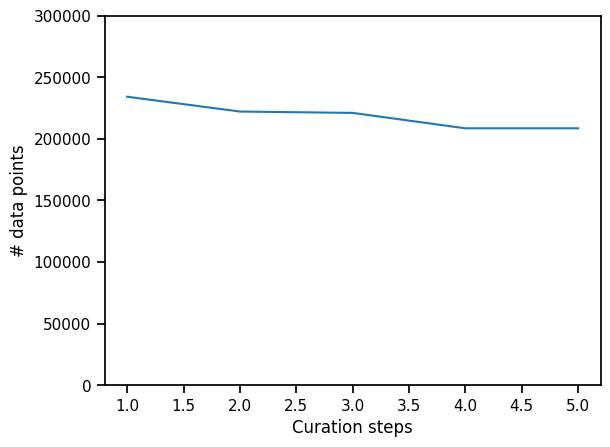

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(1, len(curated) + 1), [df.shape[0] for df in curated])
ax.set_xlabel("Curation steps")
ax.set_ylabel("# data points")
plt.xlim(0, len(curated))
plt.xticks(range(len(curated)+1))
ax.set_ylim(0, 300000);

Let's also quickly check how is the distribution of our activity values, to make sure our curation worked!

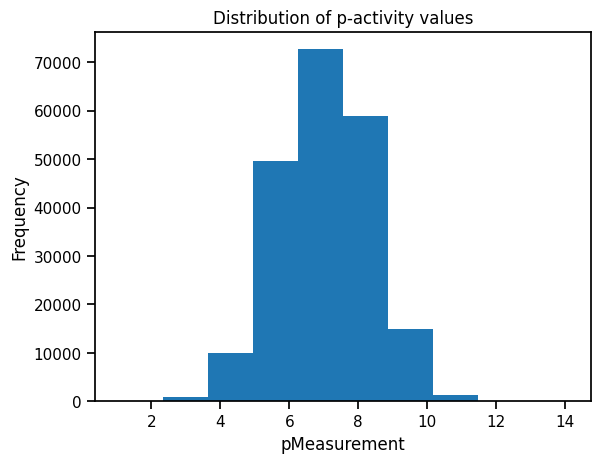

In [ ]:
final_curated["activities.standard_value"].plot.hist(title="Distribution of p-activity values", xlabel="pMeasurement");



## 2.1 Coverage distribution of ligands and targets

Why do you think analysing this is important? **QUIZ**

### Ligands

Text(0.5, 0, 'ligand')

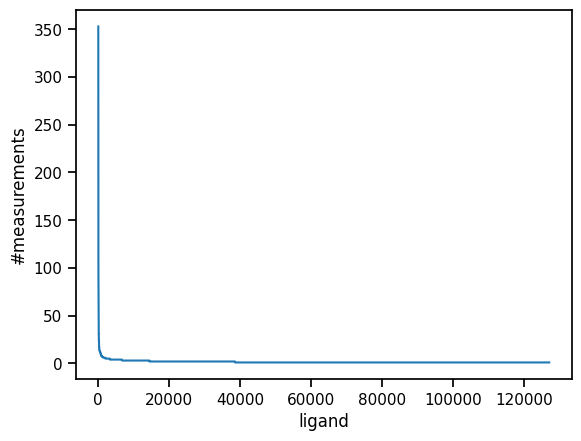

In [ ]:
ligand_counts = (
    final_curated.groupby("compound_structures.canonical_smiles")
    .count()
    .sort_values("activities.standard_value", ascending=False)
)
plt.plot(ligand_counts["activities.standard_value"].values)
plt.ylabel("#measurements")
plt.xlabel("ligand")

(0.0, 200.0)

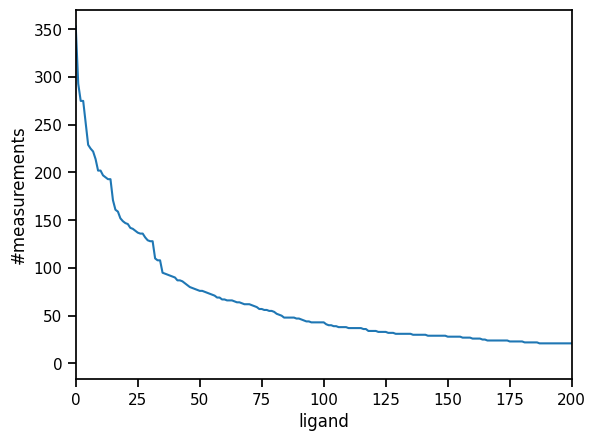

In [ ]:
#closer look 👀
plt.plot(ligand_counts["activities.standard_value"].values)
plt.ylabel("#measurements")
plt.xlabel("ligand")
plt.xlim(0,200)

Let's have a closer look into the top 10 most repeated ligands

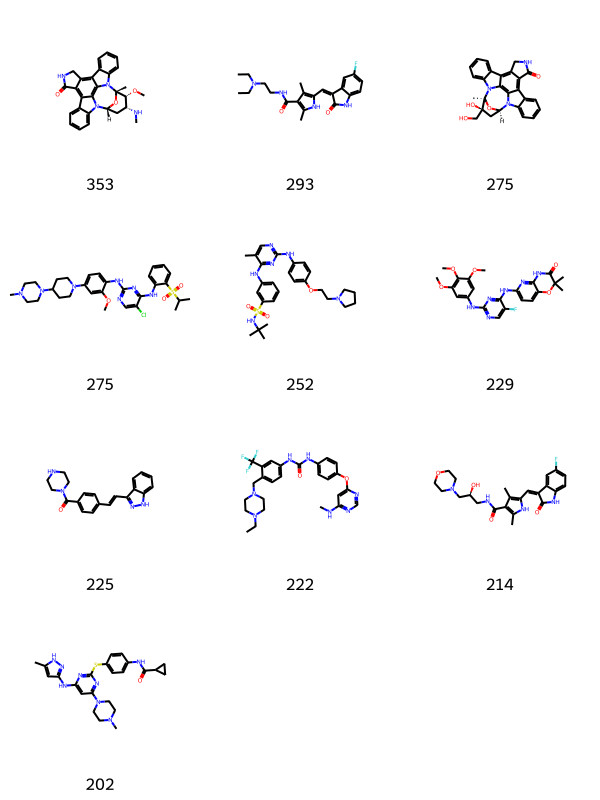

In [ ]:
top10 = ligand_counts.head(10)
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in top10.index],
    legends=list(map(str, top10.values[:, 0])),
)

### Targets

Text(0.5, 0, 'target')

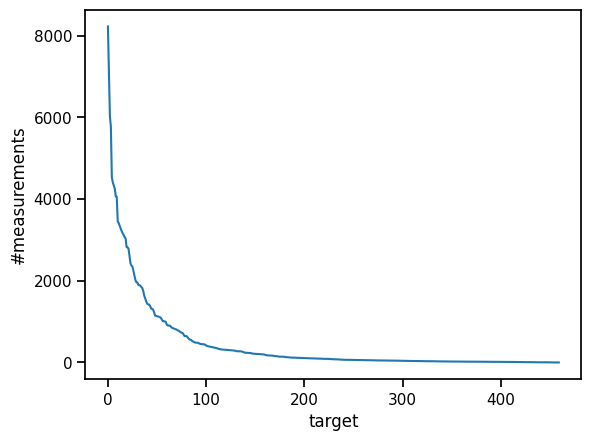

In [ ]:
target_counts = (
    final_curated.groupby("UniprotID").count().sort_values("activities.standard_value", ascending=False) #uniprotID is a unique identifier for all our targets!
)
plt.plot(target_counts["activities.standard_value"].values)
plt.ylabel("#measurements")
plt.xlabel("target")

(0.0, 200.0)

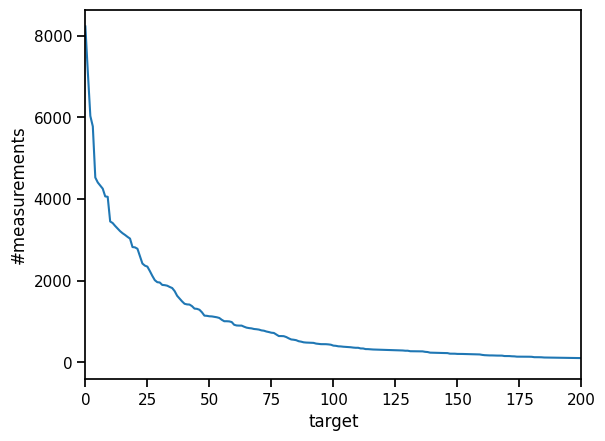

In [ ]:
#closer look 👀
plt.plot(target_counts["activities.standard_value"].values)
plt.ylabel("#measurements")
plt.xlabel("target")
plt.xlim(0,200)

It may also be of interest to know how many measurements, and which type of measurement we have per target!

In [ ]:
counts_per_target_and_measurement = pd.DataFrame(final_curated.groupby(["target_dictionary.chembl_id", "activities.standard_type"]).size(), columns=["Count"])
counts_per_target_and_measurement

Count
target_dictionary.chembl_id activities.standard_type       
CHEMBL1075102               pIC50                        23
CHEMBL1075104               pIC50                      1246
                            pKd                          24
                            pKi                         629
CHEMBL1075115               pIC50                         7
...                                                     ...
CHEMBL6167                  pKd                          34
CHEMBL6186                  pIC50                         3
                            pKd                          16
CHEMBL6191                  pIC50                         3
                            pKd                          62

[1040 rows x 1 columns]

Overall, we can conclude that not all kinases and ligands are covered equally. This information is important in terms of dividng our train/test/val datasets for our model.

## 2.2 Assay analysis

**QUIZ**: What is an assay? what examples of bioactivites assays can you think of?

First, let's have a look at how our overall assay data is distributed

In [ ]:
assay_counts=final_curated["activities.standard_type"].value_counts()
assay_counts

,count
activities.standard_type,
pIC50,177491
pKi,16416
pKd,14648


Looks like the most common one is pIC50! **QUIZ**

Another thing to look out for is the **assay confidence score**

The confidence score value reflects both the type of target assigned to a particular assay (e.g. SINGLE PROTEIN, PROTEIN FAMILY, CELL-LINE) and the confidence that the target assigned is the correct target for that assay. A specific molecular target (e.g. SINGLE PROTEIN) will have a higher score than a multi-protein target (e.g. PROTEIN FAMILY/COMPLEX) or a non-molecular target (e.g. CELL-LINE). The confidence scores range from 0, for as yet uncurated data entries, to 9, where a single protein target has been assigned a high degree of confidence.

What is the distribution of our assays confidence score?

,count
assays.confidence_score,
9,132878
8,75677


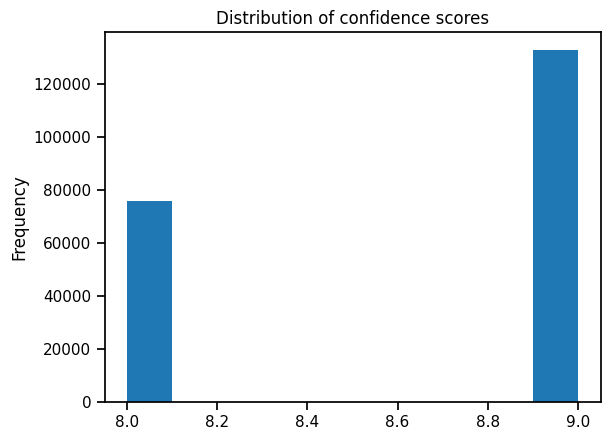

In [ ]:


display(final_curated["assays.confidence_score"].value_counts())
final_curated["assays.confidence_score"].plot.hist(title="Distribution of confidence scores");



Okay, now we are going to go into a more complex assay analysis, and for that we are going to analysis the assays with the EGFR kinases as the target.

In [ ]:
# filter for EGFR activity data
egfr = final_curated[final_curated["UniprotID"] == "P35968"].reset_index()
egfr.shape[0]

8226

To analysis the assay data coverage, we are going to convert the SMILES representation of the ligands into Morgan fingerprints

In [ ]:
# compute Morgan finterprints
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=512)
egfr.loc[:, "fingerprint"] = fps = [
    mfpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smi))
    for smi in tqdm.tqdm(egfr["compound_structures.canonical_smiles"])
]

  0%|          | 0/8226 [00:00<?, ?it/s]

Now, we compute an embedding of the generated fingerprints. We use T-SNE, which is often used to visualize high-dimensional data.
As recommended, we use PCA to reduce the initial dimensionality down to 50 before applying T-SNE.

Put simply, this type of representation will allow us to:


*   **Understanding Ligand Diversity and Clustering**: T-SNE allows you to visualize high-dimensional ligand fingerprint data, helping you understand the diversity and natural clustering of ligands based on their chemical properties. This is crucial for identifying chemical groups and exploring relationships between ligands.
*   **Dimensionality Reduction for Better Visualization**: PCA reduces the high-dimensional fingerprint data to a lower dimensional space, preserving the most important variance, making it easier for T-SNE to accurately visualize the data in 2D or 3D. This step enhances computational efficiency and produces clearer, more meaningful visualizations.
*   **Identifying Outliers and Biases**: Visualizing ligand data helps detect outliers and biases within the dataset. This allows for better dataset cleaning, ensures balanced representation, and helps identify potential errors or unique ligands with distinct biological activity.



In [ ]:
# fingerprint embedding
tsne = make_pipeline(PCA(n_components=50), TSNE(init="pca", n_jobs=8))
X = np.array([fp.astype(int) for fp in egfr["fingerprint"].values])
embedding = tsne.fit_transform(X)
egfr.loc[:, "TSNE 1"] = embedding[:, 0]
egfr.loc[:, "TSNE 2"] = embedding[:, 1]

['CHEMBL907546', 'CHEMBL5123387', 'CHEMBL949290', 'CHEMBL4686392', 'CHEMBL866859', 'CHEMBL885900', 'CHEMBL964948', 'CHEMBL4841802', 'CHEMBL4147639', 'CHEMBL812621', 'CHEMBL4223401', 'CHEMBL3102332', 'CHEMBL3888173', 'CHEMBL957977', 'CHEMBL814076', 'CHEMBL3705513', 'CHEMBL3423901', 'CHEMBL3705513', 'CHEMBL3762407', 'CHEMBL3705420']


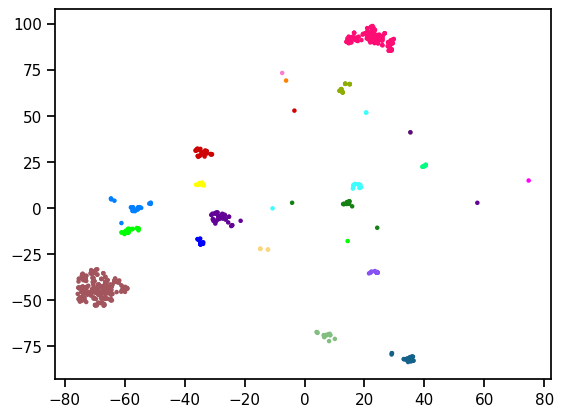

In [ ]:
N = 20 #we will take 20 assays to simplify visualization --> you can of course select the subset of assays you are interested in
sampled_assays = list(egfr["assays.chembl_id"].sample(N))
print(sampled_assays)
colors = distinctipy.get_colors(N)
data = egfr[egfr["assays.chembl_id"].isin(sampled_assays)]

#generate plot
plt.scatter(
    data['TSNE 1'].values,
    data['TSNE 2'].values,
    c=[colors[sampled_assays.index(ident)] for ident in data["assays.chembl_id"]],
    s=5
)

 It looks like ligands from the same assay (indicated by color) are normally part of the same cluster! This suggests that the ligands tested in that assay may share similar structural or chemical features. These clusters can indicate a relationship between ligand structure and activity for specific assays.

## 2.3 Distribution of clinical phases

,count
molecule_dictionary.max_phase,
4.0,3609
2.0,3051
1.0,2027
3.0,1811
-1.0,66
0.5,11


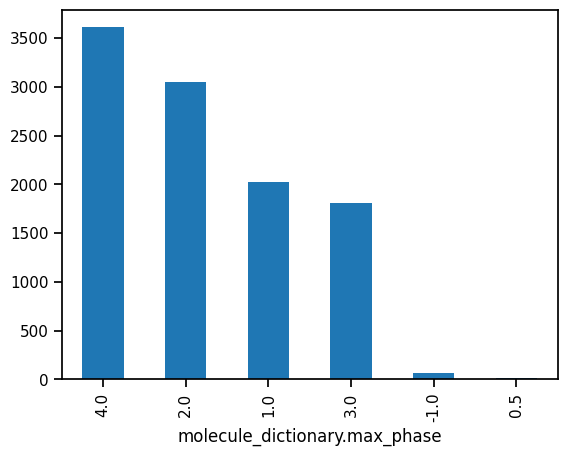

In [ ]:


phase_counts = final_curated["molecule_dictionary.max_phase"].value_counts()
display(phase_counts)
phase_counts.plot.bar();



## 2.4 Value consistency

In this analysis, we want to make see if the ligands that have the most measurements have consistent bioactivity data.  

In [ ]:
def plot_overlapping_measurements(data, name=""):

    #select the 8 compounds with more measurements
    mult10 = (
        data.groupby("compound_structures.canonical_smiles")
        .count()
        .sort_values("activities.standard_value")
        .tail(8)
        .index
    )
    #creating subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, height_ratios=[3, 10], figsize=(8, 8))

    #filter data, and from the 8 most popular compounds get the activity, assay type and ligand smiles
    egfr_1l = data[data["compound_structures.canonical_smiles"].isin(mult10)][
        ["activities.standard_value", "assays.chembl_id", "compound_structures.canonical_smiles"]
    ]

    #plot a Kernel Density Estimate: to estimate the probability density function--> used to visualize the distribution of data
    kde = sns.kdeplot(data, x="activities.standard_value", ax=ax1)
    kde.set_title(f"complete kinodata-{name} subset")

    #create a swarm plot (to avoid point overlap)
    N = len(egfr_1l["assays.chembl_id"].unique())
    colors = distinctipy.get_colors(N)
    swarm = sns.stripplot(
        data=egfr_1l,
        x="activities.standard_value",
        y="compound_structures.canonical_smiles",
        hue="assays.chembl_id",
        palette=colors,
        legend=False,
        ax=ax2,
        size=8,
    )
    swarm.set_title("8 ligands with most measurements")
    swarm.set_yticks(list(range(8)), labels=[f"{i}" for i in range(8)])
    swarm.set_ylabel("Ligand")
    swarm.set_xlabel("pIC50 [nM]")
    return fig

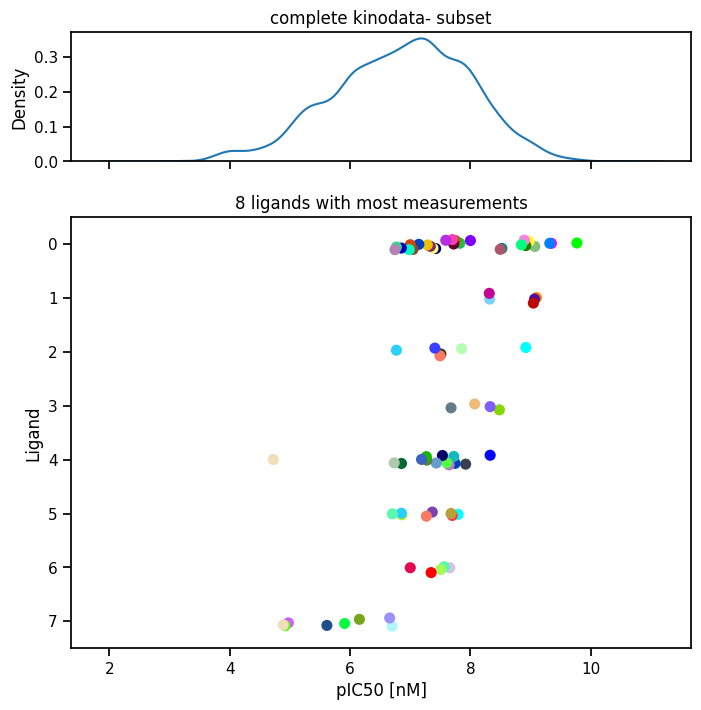

In [ ]:
plot_overlapping_measurements(egfr[egfr["activities.standard_type"] == "pIC50"]);  #we are going to check the pIC50 consistency, since we have the msot measurements for pIC50

It looks like different assays give slightly different pIC50s for the same ligand and target (EGFR) 🤔

How do you think this can affect our model? **QUIZ**

# 3. DATA SPLITS

## 3.1 *K*-fold

**QUIZ**

We need to divide our data into tran/val/test splits. A common splitting technique is k-fold splt. In k-fold splits, the data is splitted into *k* subsets, in such a way that each data point is part of the test set exactly once.

The main advantages are that:


*   **Reduces overfitting**: by testing the model on multiple subsets, k-fold provides a better estimate of model performance.
*   **Works for Small Datasets**: since all data points are used for both training and validation, it's useful when you have limited data.


For example, if we choose to do a 5-fold split, the summary of the process would be:

**Fold 1**: Train on Folds 2, 3, 4, 5 | Test on Fold 1

**Fold 2**: Train on Folds 1, 3, 4, 5 | Test on Fold 2

**Fold 3**: Train on Folds 1, 2, 4, 5 | Test on Fold 3

**Fold 4**: Train on Folds 1, 2, 3, 5 | Test on Fold 4

**Fold 5**: Train on Folds 1, 2, 3, 4 | Test on Fold 5



**QUIZ**

In [4]:
from sklearn.model_selection import KFold, train_test_split

X = final_curated.drop(columns=['activities.standard_value'])  # Features
y = final_curated['activities.standard_value']  # Target



kf = KFold(n_splits=5, shuffle=True, random_state=42)

# perform K-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Fold {fold+1}:")
    print(f"  Training fold size: {X_train.shape}")
    print(f"  Test fold size: {X_test.shape}")


NameError: name 'final_curated' is not defined

Note that: the Test Set in each fold effectively serves the role of the validation set. For each fold, the model is trained on K-1 folds and tested on the remaining fold. Since this testing fold is never seen during training, it acts like a validation set to evaluate the model's performance on unseen data.

## 3.2 Ligand scaffold

Now, insetad of just dividng the data randomly, we are gonig to divide it up based on the chemical scaffold of the ligands. This ensures that molecules with similar core structures (scaffolds) are kept together in either the training or test set, but not both. This is important in drug discovery because it ensures that the model is evaluated on ligands with new scaffolds it has not seen during training. **QUIZ**

In [ ]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# generate Bemis-Murcko scaffold from a SMILES string
def generate_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol)


In [ ]:
final_curated['scaffold'] = final_curated['compound_structures.canonical_smiles'].apply(generate_scaffold)

# check the first few scaffolds
final_curated[['compound_structures.canonical_smiles', 'scaffold']].head()

<ipython-input-164-bf1f7b9f6da5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_curated['scaffold'] = final_curated['compound_structures.canonical_smiles'].apply(generate_scaffold)


,compound_structures.canonical_smiles,scaffold
activities.activity_id,,
16291323,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,c1ccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(OCCN4CCCC4)...
16264754,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,c1ccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(OCCN4CCCC4)...
16306943,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,c1ccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(OCCN4CCCC4)...
16340050,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,c1ccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3ccccc3n2)cc1
16308267,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,c1ccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(OCCN4CCNCC4...


In [5]:
def scaffold_split(final_curated, val_size=0.1, test_size=0.2, random_state=42):
    """Perform a scaffold split to separate the dataset into train, validation, and test sets."""
    scaffolds = final_curated['scaffold'].unique() #get unique scaffolds

    # split the scaffolds into train+validation and test
    train_val_scaffolds, test_scaffolds = train_test_split(scaffolds, test_size=test_size, random_state=random_state)

    # split the train+validation scaffolds into train and validation
    train_scaffolds, val_scaffolds = train_test_split(train_val_scaffolds, test_size=val_size/(1-test_size), random_state=random_state)

    train_data = final_curated[final_curated['scaffold'].isin(train_scaffolds)]
    val_data = final_curated[final_curated['scaffold'].isin(val_scaffolds)]
    test_data = final_curated[final_curated['scaffold'].isin(test_scaffolds)]

    return train_data, val_data, test_data

#scaffold split with train, validation, and test sets
train_data, val_data, test_data = scaffold_split(final_curated)

# check the sizes of the resulting train, validation, and test sets
print(f"Training set size: {train_data.shape}")
print(f"Validation set size: {val_data.shape}")
print(f"Test set size: {test_data.shape}")

NameError: name 'final_curated' is not defined

Let's test the split now!

In [ ]:
# check if there are any shared scaffolds between train and test sets
shared_scaffolds = set(train_data['scaffold']).intersection(set(test_data['scaffold']))
print(f"Shared scaffolds: {shared_scaffolds}")  # This should be an empty set


Shared scaffolds: set()


Great, so the train and test sets do not share any scaffolds!

Now, let's combine scaffold splitting with K-fold cross-validation

In [ ]:
scaffold_groups = final_curated.groupby('scaffold').apply(lambda x: x.index.tolist())

# create KFold cross-validator for scaffold groups
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#iterate over the K folds
for fold, (train_group_index, test_group_index) in enumerate(kf.split(scaffold_groups)):
    # get the train and test scaffold groups
    train_scaffolds = scaffold_groups.iloc[train_group_index]
    test_scaffolds = scaffold_groups.iloc[test_group_index]

    # get the actual train/test indices from the scaffold groups
    train_indices = [idx for sublist in train_scaffolds for idx in sublist]
    test_indices = [idx for sublist in test_scaffolds for idx in sublist]

    # Ccreate train and test sets
    X_train = final_curated.loc[train_indices].drop(columns=['activities.standard_value'])
    y_train = final_curated.loc[train_indices]['activities.standard_value']
    X_test = final_curated.loc[test_indices].drop(columns=['activities.standard_value'])
    y_test = final_curated.loc[test_indices]['activities.standard_value']

    print(f"Fold {fold+1}:")
    print(f"  Training fold size: {X_train.shape}")
    print(f"  Test fold size: {X_test.shape}")
    shared_scaffolds = set(X_train['scaffold']).intersection(set(X_test['scaffold']))
    print(f"Shared scaffolds: {shared_scaffolds}")  # This should be an empty set


Fold 1:
  Training fold size: (166091, 15)
  Validation fold size: (42464, 15)
Shared scaffolds: set()
Fold 2:
  Training fold size: (168661, 15)
  Validation fold size: (39894, 15)
Shared scaffolds: set()
Fold 3:
  Training fold size: (166849, 15)
  Validation fold size: (41706, 15)
Shared scaffolds: set()
Fold 4:
  Training fold size: (166990, 15)
  Validation fold size: (41565, 15)
Shared scaffolds: set()
Fold 5:
  Training fold size: (165629, 15)
  Validation fold size: (42926, 15)
Shared scaffolds: set()


## 3.2 Protein sequence

**QUIZ**


 This type of split is useful in kinase drug discovery because it ensures that the model is trained on a subset of proteins and tested on entirely different proteins. This helps evaluate the model’s ability to generalize across different kinases (or other target proteins).

In [ ]:

protein_groups = final_curated.groupby('component_sequences.sequence').apply(lambda x: x.index.tolist()) #we could also group by UniprotID

#Create KFold cross-validator for protein groups
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Iterate over the K folds
for fold, (train_group_index, test_group_index) in enumerate(kf.split(protein_groups)):
    # Get the train and test protein groups
    train_proteins = protein_groups.iloc[train_group_index]
    test_proteins = protein_groups.iloc[test_group_index]

    # Get the actual train/test indices from the protein groups
    train_indices = [idx for sublist in train_proteins for idx in sublist]
    test_indices = [idx for sublist in test_proteins for idx in sublist]

    # Create train and test sets
    X_train = final_curated.loc[train_indices].drop(columns=['activities.standard_value'])
    y_train = final_curated.loc[train_indices]['activities.standard_value']
    X_test = final_curated.loc[test_indices].drop(columns=['activities.standard_value'])
    y_test = final_curated.loc[test_indices]['activities.standard_value']

    print(f"Fold {fold+1}:")
    print(f"  Training fold size: {X_train.shape}")
    print(f"  Test fold size: {X_test.shape}")
    shared_scaffolds = set(X_train['component_sequences.sequence']).intersection(set(X_test['component_sequences.sequence']))
    print(f"Shared scaffolds: {shared_scaffolds}")  # This should be an empty set



Fold 1:
  Training fold size: (163289, 15)
  Validation fold size: (45266, 15)
Shared scaffolds: set()
Fold 2:
  Training fold size: (180069, 15)
  Validation fold size: (28486, 15)
Shared scaffolds: set()
Fold 3:
  Training fold size: (156154, 15)
  Validation fold size: (52401, 15)
Shared scaffolds: set()
Fold 4:
  Training fold size: (158365, 15)
  Validation fold size: (50190, 15)
Shared scaffolds: set()
Fold 5:
  Training fold size: (176343, 15)
  Validation fold size: (32212, 15)
Shared scaffolds: set()


## 3.4 Real World example

In this paper: *Backenköhler, M., Groß, J., Wolf, V., & Volkamer, A. (2024). Guided docking as a data generation approach facilitates structure-based machine learning on kinases. Journal of Chemical Information and Modeling.* We can see in the results of their model, a clear example of how model performance varies depending on the type of data split they choose:

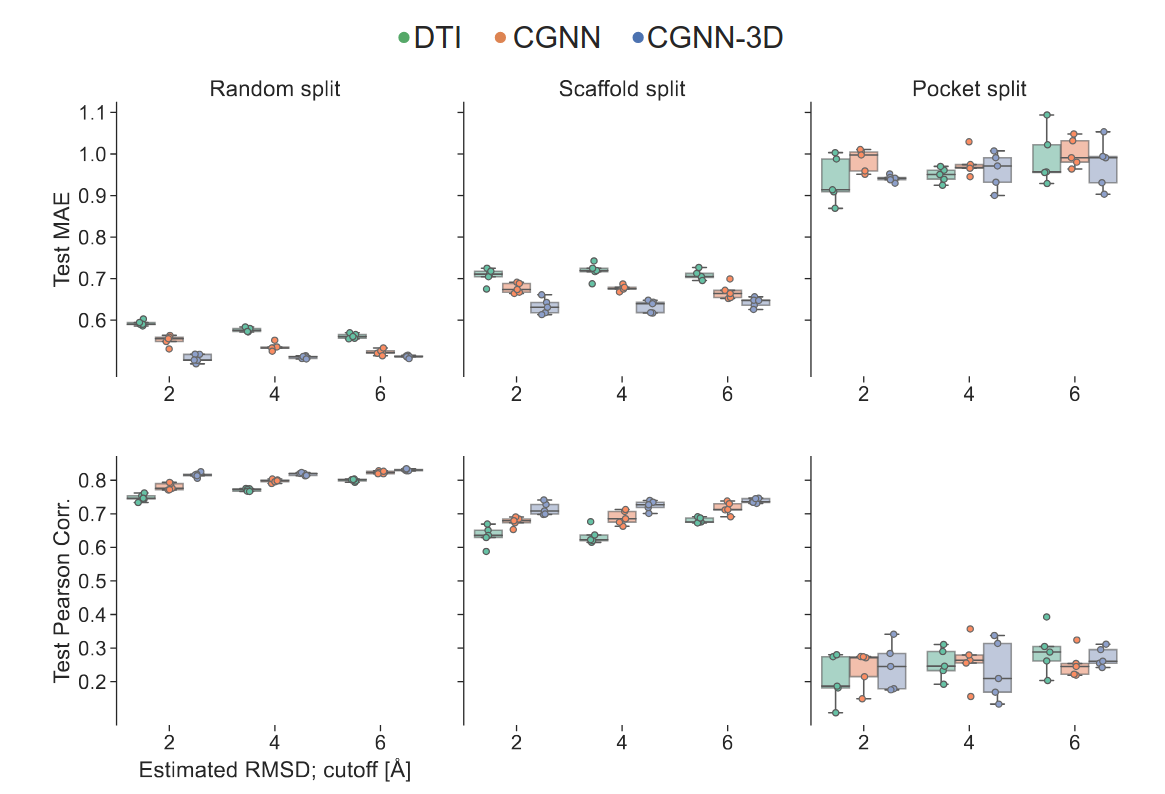